In [1]:
import tensorflow as tf
from tensorflow import keras
from threading import Thread
import time
import numpy as np
import cv2 as cv
import pandas as pd
import playsound
import matplotlib.pyplot as plt
import math
from scipy.spatial import distance
from tensorflow.python.keras.utils.vis_utils import plot_model
from statistics import mean
import datetime as dt
from keras import Model
import tensorflow.keras.backend as K

In [2]:
model = keras.models.load_model('TRY_07.h5')

In [3]:
layer_names = [layer.name for layer in model.layers[:-4]]
#layer_names

In [4]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [25]:
def read_and_preprocess_img(ff1):
    ff1 = cv.resize(ff1, (224, 224))
    ff1 = cv.cvtColor(ff1, cv.COLOR_BGR2RGB)
    plt.figure(figsize=(8, 8))
    plt.imshow(ff1)
    plt.axis('off')
    plt.show()
    ff1 = np.expand_dims(ff1, axis = 0)
    return ff1

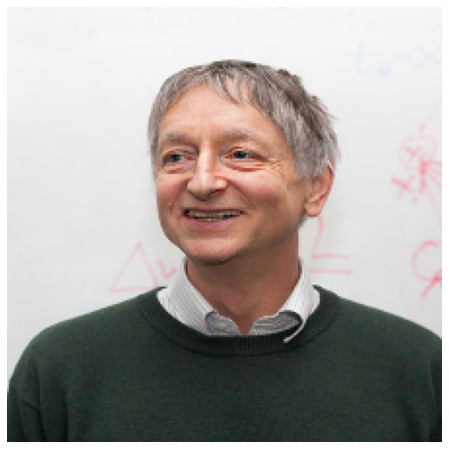

In [26]:
img_array = cv.imread('FBBVA-16-tic-hinton.jpg')
img_array = read_and_preprocess_img(img_array)

In [27]:
layer_name = 'activation_6'

In [28]:
model_grad = Model([model.inputs], 
                       [model.get_layer(layer_name).output,model.layers[-3].output,model.layers[-2].output,model.layers[-1].output])

In [29]:
inputs = img_array
with tf.GradientTape(persistent = True) as tape:   

    # generate the predictions
    features, Confidence_Score, bounding_box, Facial_Landmarks = model_grad(inputs)

# get the gradient with respect to the inputs
gradients = tape.gradient(Facial_Landmarks, features)

In [30]:
print(np.max(gradients), np.min(gradients))
print(gradients.shape, gradients)

6.330862 -5.988248
(1, 27, 27, 512) tf.Tensor(
[[[[ 0.06729504  0.          0.11622737 ...  0.          0.
     0.10648828]
   [ 0.01342665  0.          0.10770666 ...  0.          0.
     0.09391645]
   [-0.05873452  0.         -0.01630757 ...  0.          0.
    -0.02619922]
   ...
   [ 0.          0.          0.         ...  0.          0.
     0.08781926]
   [ 0.          0.         -0.00817244 ...  0.          0.05058493
     0.09358078]
   [ 0.          0.         -0.14110264 ...  0.          0.00422803
     0.01121182]]

  [[ 0.03681383  0.         -0.00984479 ...  0.          0.
    -0.05697056]
   [ 0.01136605  0.         -0.00401906 ...  0.          0.
    -0.04766979]
   [-0.04555019  0.         -0.02189137 ...  0.          0.
    -0.03330551]
   ...
   [ 0.         -0.01227338  0.02737772 ...  0.          0.
    -0.03531182]
   [ 0.         -0.00106933 -0.02733896 ...  0.          0.00909129
    -0.04096529]
   [ 0.         -0.00559164  0.01297104 ...  0.          0.0020059

In [31]:
positive_gradients = np.maximum(gradients, 0)
print(np.max(positive_gradients), np.min(positive_gradients))
print(positive_gradients.shape, positive_gradients)

6.330862 0.0
(1, 27, 27, 512) [[[[0.06729504 0.         0.11622737 ... 0.         0.
    0.10648828]
   [0.01342665 0.         0.10770666 ... 0.         0.
    0.09391645]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   ...
   [0.         0.         0.         ... 0.         0.
    0.08781926]
   [0.         0.         0.         ... 0.         0.05058493
    0.09358078]
   [0.         0.         0.         ... 0.         0.00422803
    0.01121182]]

  [[0.03681383 0.         0.         ... 0.         0.
    0.        ]
   [0.01136605 0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   ...
   [0.         0.         0.02737772 ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.00909129
    0.        ]
   [0.         0.         0.01297104 ... 0.         0.00200591
    0.        ]]

  [[0.         0.03713579 0.00832986 ... 0.         0.
    0.0181909

In [32]:
print(features.shape)
features = np.squeeze(features)
positive_gradients = np.squeeze(positive_gradients)
print(features.shape, positive_gradients.shape)

(1, 27, 27, 512)
(27, 27, 512) (27, 27, 512)


In [33]:
heatmap = features * positive_gradients
print(heatmap.shape)

(27, 27, 512)


In [34]:
heatmap = np.sum(heatmap, axis = 2)
print(heatmap.shape)

(27, 27)


In [35]:
print(np.max(heatmap), np.min(heatmap))

97.71754 2.008226


In [36]:
heatmap = np.maximum(heatmap, 0)
print(np.max(heatmap), np.min(heatmap))

97.71754 2.008226


In [37]:
heatmap /= np.max(heatmap)
print(np.max(heatmap), np.min(heatmap))

1.0 0.020551335


In [38]:
heatmap = cv.resize(heatmap, (224, 224))
heatmap = heatmap *255
heatmap = heatmap.astype(np.uint8)

In [39]:
print(np.max(heatmap), np.min(heatmap))

249 5


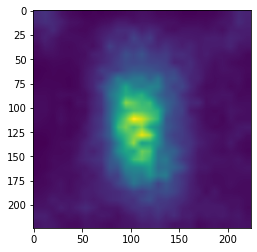

In [40]:
plt.imshow(heatmap)
plt.show()

In [41]:
heatmap = cv.applyColorMap(heatmap, cv.COLORMAP_JET)

In [42]:
img_array = img_array.reshape(224,224,3)

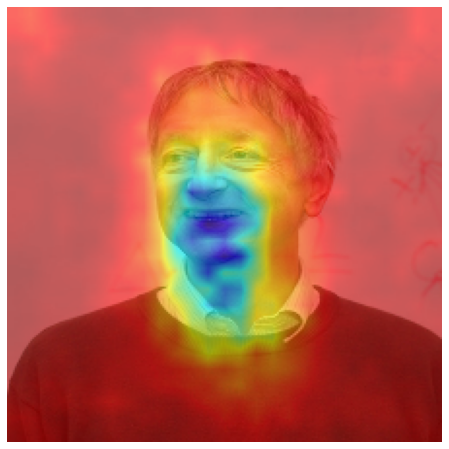

In [43]:
super_imposed = cv.addWeighted(img_array, 0.4, heatmap, 0.6, 0.0)
plt.figure(figsize=(8, 8))
plt.imshow(super_imposed)
plt.axis('off')
plt.show()

<ipython-input-44-247b3a51d07e>:4: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  cv.circle(super_imposed, (i[0], i[1]), 1, (0,0,0), -1)


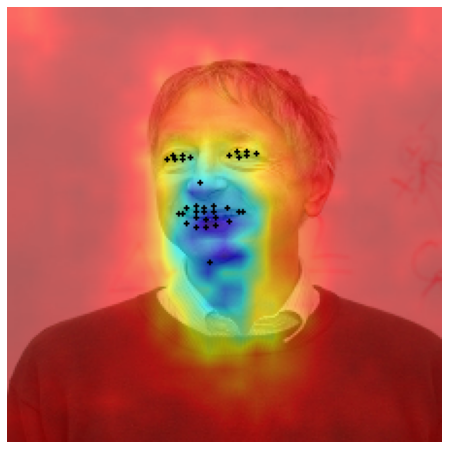

In [44]:
Facial_Landmarks = np.array(Facial_Landmarks)
FLP = Facial_Landmarks.reshape(34, 2)
for i in FLP:
            cv.circle(super_imposed, (i[0], i[1]), 1, (0,0,0), -1)
plt.figure(figsize=(8, 8))
plt.imshow(super_imposed)
plt.axis('off')
plt.show()